# Playoff Profit: Does profit really outperform in the playoffs?

The goal is to create a stastic that can be used to evaluate player contribution towards a win in the Overwatch League (OWL)

Process:
* Prepare data for analyses through combining and cleaning
* Test different models to determine best model for predicting wins using player stats
* Use best model to create a general statistic that can demonstrate player contribution towards a win
* Compare the stastic between regular season and playoff play

## Importing/Combining Data

### Importing

In [13]:
# Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

### Reading/Combining Data

* The data is split based on stage (for 2018 and 2019) or part of season (for 2020 and 2021) and year
* This test file only uses the 2018 season for predictions
* Simplified maps dataset to 1 entry per map played instead of including each round of every map

In [14]:
s1_2018 = pd.read_csv('phs_2018_stage_1.csv')
s2_2018 = pd.read_csv('phs_2018_stage_2.csv')
s3_2018 = pd.read_csv('phs_2018_stage_3.csv')
s4_2018 = pd.read_csv('phs_2018_stage_4.csv')
playoffs_2018 = pd.read_csv('phs_2018_playoffs.csv')

df_list = [s1_2018, s2_2018, s3_2018, s4_2018, playoffs_2018]
stats = pd.concat(df_list)

In [15]:
maps = pd.read_csv('match_map_stats_000000000000.csv')
maps = maps[['match_id', 'map_name', 'match_winner', 'map_winner']]
maps = maps.drop_duplicates()

## Cleaning Data

#### Combining rows

* The dataset contains one row per stat, player, map, and hero
* These rows were combined into one entry per player, map, and hero with all stats in one row

In [16]:
stats = stats.pivot_table(
    index=['match_id', 'map_name', 'map_type', 'team', 'player', 'hero'],
    columns='stat_name',
    values='stat_amount'
).reset_index()

#### Adding map data

* Combine map data with player stats by match_id and map_name
* Convert match_winner and map_winner to int for easier use (0 = loss, 1 = win)

In [17]:
stats = pd.merge(stats, maps, on=['match_id', 'map_name'])

stats['match_winner'] = np.where(stats.match_winner == stats.team, True, False)
stats['map_winner'] = np.where(stats.map_winner == stats.team, True, False)

#### Removing Hero-Specific Stats
* Drop columns with over 50% NaN values
* Remove "All Heroes" entries

In [18]:
thresh = len(stats) * .6
stats = stats.dropna(thresh = thresh, axis = 1)

In [19]:
stats = stats[stats['hero'] != 'All Heroes']

#### Resulting DataFrame

In [20]:
stats.head(5)

### Saving for use in part 2

In [ ]:
stats.to_csv('OWL_stats.csv', index=False)

## Preparing Data
* Requires choosing either map wins or match wins to predict

#### X/Y split
* Can choose between predicting match or map wins by changing value in train/test split, default is map
* Focus only on the stats, ignore names, teams, and maps

In [21]:
y_match = stats['match_winner'] # Predicts match wins
y_map = stats['map_winner'] # Predicts map wins

X = stats.drop(['player', 'team', 'map_name', 'hero', 'map_type'], axis=1)
X = X.drop(['match_winner', 'map_winner', 'match_id'], axis=1)

#### Preprocessing
* Fill NaN values with 0, as most represent stat not being registered (no healing/no damage)

In [22]:
from sklearn.model_selection import train_test_split

X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y_map, test_size=0.2, random_state=42)

## Modeling Data

### Random Forest

* Slightly more false negatives than false positives, but hard to determine why

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
rf_clf.fit(X_train, y_train)

print('Train accuracy score:', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Test accuracy score:', accuracy_score(y_test, rf_clf.predict(X_test)))

Train accuracy score: 0.999615809441483
Test accuracy score: 0.7166730695351518


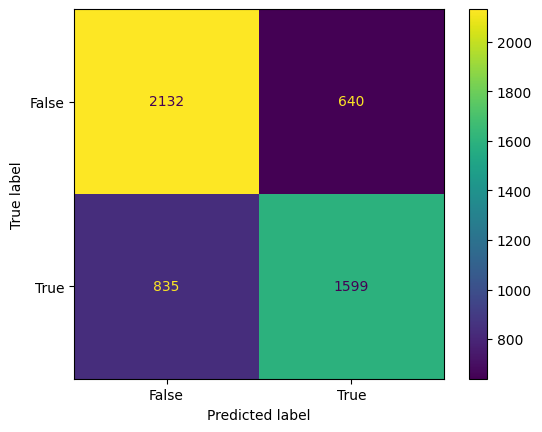

In [24]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

## Improving Model

### Using Correlation

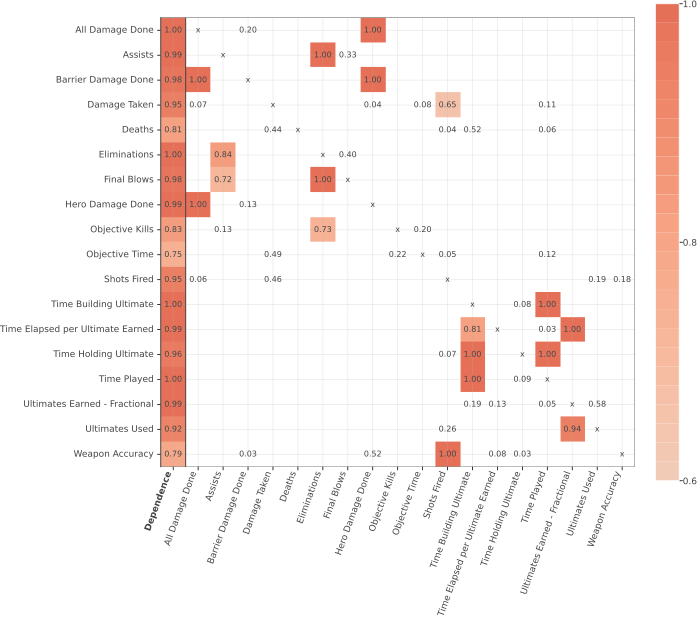

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import rfpimp

dependence_matrix = rfpimp.feature_dependence_matrix(X_train,
                          rfrmodel=RandomForestRegressor(n_estimators=50, oob_score=True, n_jobs=-1),
                          rfcmodel=RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=-1),
                          cat_count=20,
                          zero=0.001,
                          sort_by_dependence=False,
                          n_samples=5000)

plt.rcParams["figure.figsize"] = (10,10)
rfpimp.plot_dependence_heatmap(dependence_matrix)

Looking at the heatmap produced above, there appears to be high correlation between:
* All Damage Done, Barrier Damage Done, and Hero Damage Done
* Assists, Eliminations, Objective Kills, and Final Blows
* Shots Fired and Weapon Accuracy
* Time Building Ultimate, Time Played, Time Holding Ultimate, and Deaths
* Ultimates Earned - Fractional, Time Elapsed per Ultimate Earned, and Damage Taken

### Feature Importance
Using the conclusions drawn from the correlation heat map, highly correlated features were combined then used to produce a feature importance graph. Objective Time and Ultimates Used did not have high correlation with any other features.

Another feature importance graph was generated to show each feature seperately.

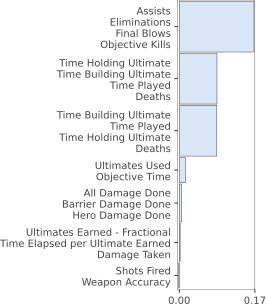

In [26]:
combined_features = [['All Damage Done', 'Barrier Damage Done', 'Hero Damage Done'],
                    ['Assists', 'Eliminations', 'Final Blows', 'Objective Kills'], 
                    ['Shots Fired', 'Weapon Accuracy'],
                    ['Time Building Ultimate', 'Time Played', 'Time Holding Ultimate', 'Deaths'],
                    ['Time Holding Ultimate', 'Time Building Ultimate', 'Time Played', 'Deaths'], 
                    ['Ultimates Earned - Fractional', 'Time Elapsed per Ultimate Earned', 'Damage Taken']]

cmb_imp = rfpimp.importances(rf_clf, X_test, y_test, features=combined_features)
rfpimp.plot_importances(cmb_imp)

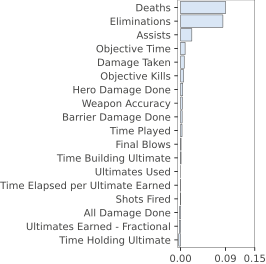

In [27]:
sep_imp = rfpimp.importances(rf_clf, X_test, y_test, features=X.columns)
rfpimp.plot_importances(sep_imp)

### Removing Collinear Features

#### Assists, Eliminations, Objective Kills, and Final Blows

All of are part of eliminating an opponent, but certain roles may be more likely to get assists than eliminations. However, objective kills and final blows can be more random elements as they are based on location of the elimination and getting in the last bit of damage. As a result, final blows and objective kills will be dropped.

#### Time Building Ultimate, Time Played, Time Holding Ultimate, and Deaths

Time played can be derived from time building and holding ultimate, while deaths appears to be the most important feature on its own. However, time played can be used to regularize stats over a given time period (i.e. per 10 minutes), so it will not be dropped.

#### All Damage Done, Barrier Damage Done, and Hero Damage Done

Barrier damage done and hero damage done can both be used to calculate all damage done. As a result, all damage done will be dropped.

#### Shots Fired and Weapon Accuracy

Both of these have high variance depending on the hero being played, making them have little impact in this model that does not factor in the hero being played.

#### Ultimates Earned - Fractional, Time Elapsed per Ultimate Earned, and Damage Taken

Ultimates earned and time elapsed per ultimate earned are very similar, whearas damage taken has no direct impact on ultimates earned (although it can have an impact on ultimates earned for teammates). Ultimates earned will be dropped as it has slightly less importance on its own.

### Rebuilding the Model

The model is retrained with the aforementioned columns dropped.

In [28]:
new_X = X.drop(['Final Blows', 'Objective Kills', 'Time Played', 'All Damage Done',
            'Ultimates Earned - Fractional'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(new_X, y_map, test_size=0.2, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

new_rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
new_rf_clf.fit(X_train, y_train)

print('Train accuracy score:', accuracy_score(y_train, new_rf_clf.predict(X_train)))
print('Test accuracy score:', accuracy_score(y_test, new_rf_clf.predict(X_test)))

Train accuracy score: 0.9976468328290832
Test accuracy score: 0.7226277372262774


                                  Importance
Feature                                     
Eliminations                          0.1358
Deaths                                0.1164
Assists                               0.0308
Objective Time                        0.0160
Time Building Ultimate                0.0104
Damage Taken                          0.0084
Hero Damage Done                      0.0048
Time Holding Ultimate                 0.0042
Barrier Damage Done                   0.0014
Shots Fired                          -0.0006
Weapon Accuracy                      -0.0012
Ultimates Used                       -0.0022
Time Elapsed per Ultimate Earned     -0.0028


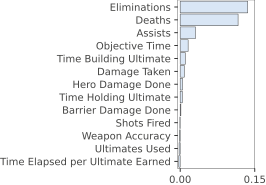

In [41]:
sep_imp = rfpimp.importances(new_rf_clf, X_test, y_test, features=new_X.columns)
print(sep_imp)
rfpimp.plot_importances(sep_imp)

### Results

There appears to be little to no gain in accuracy when comparing the original model to the new model after removing collinear features. This is a positive though, as it means less features can be used to build our statistic without having to worry about a loss in predictive accuracy.

In [33]:
stat_df['Time Played'] = stat_df['Time Played'].multiply(1.0/60.0)

for i in stat_df.columns[2:12]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])
    
for i in stat_df.columns[14:15]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])

stat_df.drop('Time Played', axis=1, inplace=True)

In [34]:
sep_imp

,Importance
Feature,
Eliminations,0.1270
Deaths,0.1008
Assists,0.0362
Damage Taken,0.0164
Objective Time,0.0080
Hero Damage Done,0.0078
Time Holding Ultimate,0.0056
Time Building Ultimate,0.0054
Shots Fired,0.0046


In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_imp = scaler.fit_transform(sep_imp.to_numpy())
scale_imp[0] *= -1
scale_imp[5] *= -1

x = stat_df.select_dtypes(float).columns
#temp = np.dot(stat_df[x], scale_imp)
#stat_df['Stat'] = temp
scale_imp

array([[-1.        ],
       [ 0.7962675 ],
       [ 0.29393468],
       [ 0.1399689 ],
       [ 0.07465008],
       [-0.07309487],
       [ 0.05598756],
       [ 0.05443235],
       [ 0.04821151],
       [ 0.03888025],
       [ 0.03576983],
       [ 0.03265941],
       [ 0.        ]])

Some players did not have enough play time to register stats, and as such will not have a statistic for their play

In [36]:
stat_df = stat_df[stat_df['Stat'].notna()]
stat_df.head(5)

KeyError: 'Stat'

### Comparison

Based on the accuracy score, it is clear the stat is not much better than randomly selecting a win or loss, and this is evidenced by the confusion matrix which shows an even distribution within all possible outcomes.

In [243]:
y_match = stat_df['match_winner'] # Predicts match wins
y_map = stat_df['map_winner'] # Predicts map wins

X = stat_df[['Stat']]

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_match, test_size=0.2, random_state=42)

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
rf_clf.fit(X_train, y_train)

print('Train accuracy score:', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Test accuracy score:', accuracy_score(y_test, rf_clf.predict(X_test)))

Train accuracy score: 0.9972611567584985
Test accuracy score: 0.522229381443299


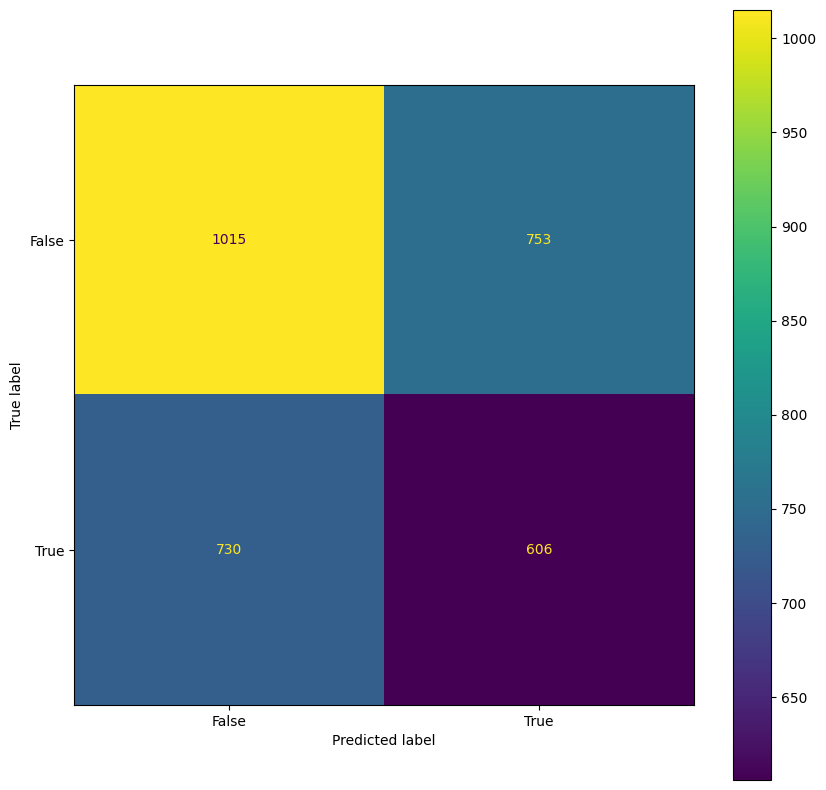

In [246]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

### Conclusion

The main issue from looking at individuals stats in comparison to the combined stat is that certain stats are easier to accumulate (hero damage, shots fired) than other stats (eliminations, deaths). While easier to accumulate stats appear to have less importance, when simply scaled and multiplied, their importance becomes much more significant, so all of the stats may need to be scaled to give a more accurate depiction for a stat.

In [322]:
stat_df = stats.drop(['match_id', 'Final Blows',
                           'Objective Kills', 'All Damage Done',
                            'Ultimates Earned - Fractional', 'team', 'map_name', 'map_type'], axis=1)
stat_df[['Shots Fired', 'Weapon Accuracy', 'Ultimates Used']] = stat_df[['Shots Fired', 'Weapon Accuracy', 'Ultimates Used']].fillna(value=0)
stat_df['Damage Taken'].fillna(value=stat_df['Damage Taken'].mean(), inplace = True)

In [323]:
from sklearn.preprocessing import MinMaxScaler

stat_df['Time Played'] = stat_df['Time Played'].multiply(1.0/60.0)

for i in stat_df.columns[2:12]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])
    
for i in stat_df.columns[14:15]:
    stat_df[i] = stat_df[i].multiply(10.0/stat_df['Time Played'])

stat_df.drop('Time Played', axis=1, inplace=True)

In [324]:
stat_df

,player,hero,Assists,Barrier Damage Done,Damage Taken,Deaths,Eliminations,Hero Damage Done,Objective Time,Shots Fired,Time Building Ultimate,Time Elapsed per Ultimate Earned,Time Holding Ultimate,Ultimates Used,Weapon Accuracy,match_winner,map_winner
1,Agilities,Genji,12.196102,2075.962552,4567.276964,7.891596,22.957369,10799.926734,21.247762,760.462848,498.026416,55.763771,94.136003,5.739342,0.273585,True,True
3,Envy,D.Va,17.218027,3565.763663,12563.344798,5.739342,25.827040,7946.896129,84.016795,11500.207033,452.112394,45.767412,206.948006,16.500609,0.314785,True,True
5,Fate,Winston,16.500609,1066.567565,12797.300699,8.609013,23.674787,6391.757292,55.572615,0.000000,461.853493,74.577728,143.093004,3.587089,0.000000,True,True
7,KariV,Mercy,1.434836,14.348356,1990.345310,5.021924,1.434836,251.096223,57.616539,27.979293,383.803458,67.761582,217.043006,3.587089,0.333333,True,True
9,SoOn,Tracer,12.788479,2686.696732,3143.891491,5.594959,22.379838,8994.409591,55.613896,4498.347378,545.789907,52.048261,65.665002,7.193519,0.376155,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39306,carpe,Widowmaker,1.751386,227.680132,2974.136660,10.508314,5.254157,6776.657119,5.357489,243.442603,511.218973,166.767755,7.358000,5.254157,0.596774,False,False
39308,eqo,Pharah,2.922108,2092.229156,4086.674323,8.766323,2.922108,5171.774021,4.193225,280.522345,487.334536,384.843147,38.926001,0.000000,0.323944,False,False
39309,eqo,Tracer,3.129015,549.341628,3173.392424,9.387044,9.387044,5928.466699,68.469099,4217.911675,510.583230,223.417399,27.958001,6.258029,0.406306,False,False
39311,neptuNo,Lúcio,NaN,NaN,254368.675198,NaN,NaN,NaN,NaN,0.000000,720.140957,42008.221819,NaN,0.000000,0.000000,False,False


In [325]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=False)
scale_imp = scaler.fit_transform(sep_imp.to_numpy())
scale_imp[0] *= -1
scale_imp[5] *= -1

x = stat_df.select_dtypes(float).columns
scaler.fit_transform(stat_df[x])
temp = np.dot(stat_df[x], scale_imp)
stat_df['Stat'] = temp
scale_imp

stat_df = stat_df[stat_df['Stat'].notna()]

In [326]:
heroes = stat_df['hero'].unique()
averages = {}

for hero in heroes:
    hero_df = stat_df[stat_df['hero'] == hero]
    averages[hero] = hero_df['Stat'].mean()

In [327]:
def func(stat, hero):
    return stat * 1.0/averages[hero]

stat_df['Stat'] = stat_df.apply((lambda x: func(x['Stat'], x['hero'])), axis=1)

In [328]:
stat_df[stat_df['hero']=='Tracer'].sort_values(by='Stat', ascending=False)

,player,hero,Assists,Barrier Damage Done,Damage Taken,Deaths,Eliminations,Hero Damage Done,Objective Time,Shots Fired,Time Building Ultimate,Time Elapsed per Ultimate Earned,Time Holding Ultimate,Ultimates Used,Weapon Accuracy,match_winner,map_winner,Stat
38973,SAEBYEOLBE,Tracer,5.314299,7708.059264,3709.290498,15.942898,5.314299,5933.633419,16.740043,3666.866558,474.992091,431.647084,24.345001,5.314299,0.582697,False,False,3.598515
25109,SoOn,Tracer,4.814315,5689.845645,3585.886433,9.628631,4.814315,3264.460373,93.214778,2984.875549,503.909594,503.909594,19.705001,0.000000,0.457447,True,False,3.246715
35036,Munchkin,Tracer,6.631831,6009.161054,3743.038513,6.631831,19.895492,6256.179641,63.181449,3713.825093,595.319548,571.832054,0.364000,6.631831,0.442049,False,False,3.001253
26185,STRIKER,Tracer,5.554385,7315.325886,6635.206124,11.108769,16.663154,16715.074066,87.209391,7298.461336,558.265656,205.085446,7.434000,11.108769,0.514146,False,False,2.855326
25886,Wekeed,Tracer,13.044077,6043.061948,3989.565605,3.261019,22.827134,9079.999315,63.915978,5674.173392,414.162493,192.128809,57.162002,6.522038,0.492470,True,False,2.847235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,carpe,Tracer,17.869794,468.967671,2256.884018,4.467448,35.739588,11137.710735,65.077321,4476.383385,557.296346,247.666758,9.190000,8.934897,0.397861,False,True,-0.254628
34067,Surefour,Tracer,10.719932,192.958774,2032.673532,5.359966,21.439864,9330.368789,114.341477,3344.618749,526.718509,153.288038,26.166001,5.359966,0.471939,True,True,-0.325258
17887,Danteh,Tracer,12.621467,1382.323610,2997.475836,4.207156,31.553667,15899.530003,79.618319,5212.665829,488.631691,97.552911,52.931002,10.517889,0.543271,True,True,-0.552661
21854,Logix,Tracer,10.105268,1940.211481,3026.714074,10.105268,30.315804,18817.303014,122.162585,6325.897849,571.260929,443.593580,2.870000,10.105268,0.419753,False,False,-0.575926


Train accuracy score: 0.9994361205091026
Test accuracy score: 0.49162371134020616


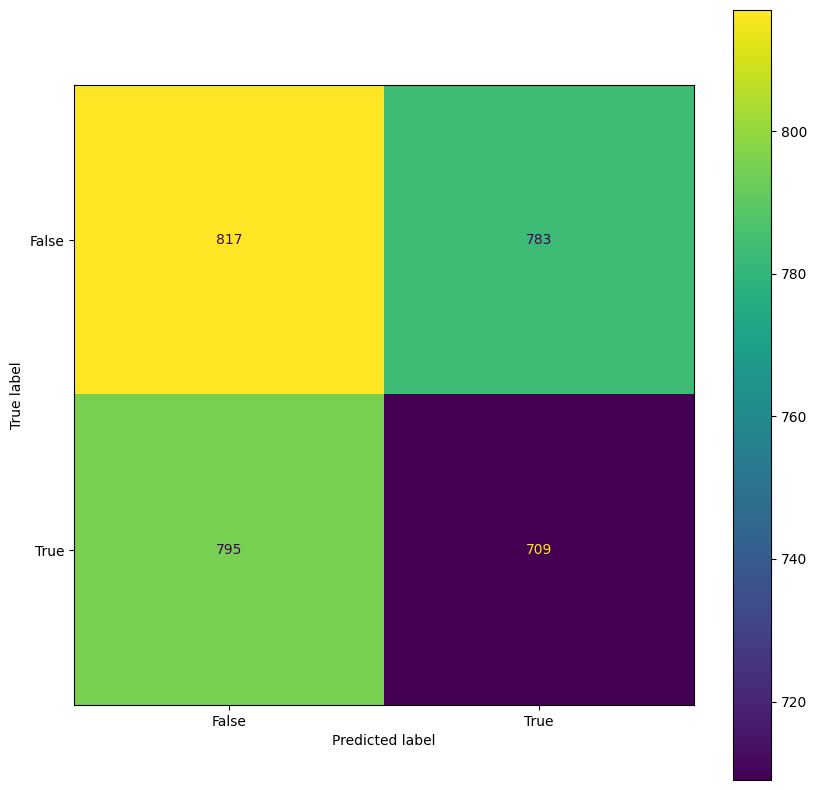

In [249]:
y_match = stat_df['match_winner'] # Predicts match wins
y_map = stat_df['map_winner'] # Predicts map wins

X = stat_df[['Stat']]



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_map, test_size=0.2, random_state=42)




from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
rf_clf.fit(X_train, y_train)

print('Train accuracy score:', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Test accuracy score:', accuracy_score(y_test, rf_clf.predict(X_test)))



from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)

disp.plot()
plt.show()

### Saving for use in part 2

In [43]:
sep_imp.to_csv('sep_imp.csv')